# Deep Fusion Model for UBEM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import time
import itertools
from tqdm import tqdm
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import networkx as nx
from node2vec import Node2Vec
import random
import pickle
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data_directory = r"C:\Users\said_\OneDrive\Masaüstü\github\Deep Model Fusion for UBEM\Model Development"
model_files = r"C:\Users\said_\OneDrive\Masaüstü\github\Deep Model Fusion for UBEM\Model Development\Model Files"

In [4]:
# Check if GPU is active
print("Is CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Is CUDA available: True
GPU name: NVIDIA RTX A2000 12GB


# Data Processing

In [5]:
training_data = pd.read_csv(os.path.join(data_directory, "complete_training_data.csv"))
training_data.info()

# Optional data extraction: Extract a random subset of the training data
#training_data = pd.read_csv(os.path.join(data_directory, "complete_training_data.csv"), header=0, skiprows=lambda i: i>0 and random.random()>0.01)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4993200 entries, 0 to 4993199
Data columns (total 46 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   Scenario                                       object 
 1   Building Name                                  object 
 2   Archetype                                      object 
 3   Hour                                           int64  
 4   Centroid-X                                     float64
 5   Centroid-Y                                     float64
 6   Energy Consumption                             float64
 7   Month                                          int64  
 8   Day                                            int64  
 9   Weekday                                        int64  
 10  Hours                                          int64  
 11  Dry Bulb Temperature {C}                       float64
 12  Dew Point Temperature {C}                 

In [6]:
target_feature = ['Energy Consumption']

# Define identity features
identity_features = ['Scenario', 'Building Name', 'Archetype']

# Define time-dependent data for LSTM
time_dependent_features = [
    'Month', 'Day', 'Weekday', 'Hours', 'Dry Bulb Temperature {C}',
    'Dew Point Temperature {C}', 'Relative Humidity {%}',
    'Wind Direction (deg)', 'Wind Speed (m/s)',
    'Hourly Total Global Solar Radiation (watt/m2)',
    'Liquid Precipitation (mm)', 'Sun Exposure Intensity (cal/cm2)',
    'Heating Schedule', 'Cooling Schedule', 'DHW Schedule',
    'Equipment Schedule', 'Lighting Schedule', 'Occupant Schedule',
    'Natural Ventilation Schedule', 'Mechanical Ventilation Schedule',
] 

# Define static data for feed-forward NN
static_features = [
    'DHW Flow Rate (m3/h/m2)', 'Illuminance (lux)',
    'Occupant Density (people/m2)', 'Infiltration (ACH)',
    'Cooling Setpoint (celsius)', 'Ground-U', 'IsCoolingOn', 'IsMechVentOn',
    'lpd', 'heating_setpoint', 'wall_u', 'roof_u', 'window_u',
    'WWR','Rhino GFA (m2)', 'Floor Count', 'Height', 'Volume',
]

# Define geometrical data for graph embeddings
geometrical_features = [
    'Centroid-X', 'Centroid-Y', 'Rhino GFA (m2)', 
    'Floor Count', 'Height', 'Volume',
]

columns_order = target_feature + identity_features + time_dependent_features + static_features
new_df = training_data[columns_order].copy()
print(new_df.shape)

(4993200, 42)


In [7]:
new_df.sample(10)

,Energy Consumption,Scenario,Building Name,Archetype,Month,Day,Weekday,Hours,Dry Bulb Temperature {C},Dew Point Temperature {C},Relative Humidity {%},Wind Direction (deg),Wind Speed (m/s),Hourly Total Global Solar Radiation (watt/m2),Liquid Precipitation (mm),Sun Exposure Intensity (cal/cm2),Heating Schedule,Cooling Schedule,DHW Schedule,Equipment Schedule,Lighting Schedule,Occupant Schedule,Natural Ventilation Schedule,Mechanical Ventilation Schedule,DHW Flow Rate (m3/h/m2),Illuminance (lux),Occupant Density (people/m2),Infiltration (ACH),Cooling Setpoint (celsius),Ground-U,IsCoolingOn,IsMechVentOn,lpd,heating_setpoint,wall_u,roof_u,window_u,WWR,Rhino GFA (m2),Floor Count,Height,Volume
4313872,2.589021,S26,İdari Bina B Blok,Ofis,6,14,3,16,20.9,16.9,78,338,2.2,5340,0.0,0.0,0,1,0.4,1.0,1.0,1.0,0.5,0.5,0.00180,500,0.054,0.60,24.1,0.591,1,0,4,18,0.300,0.300,1.200,0.245,1618,3,9,14562
310179,141.236465,S2,Şefkat Sitesi,Huzurevi,5,30,2,3,16.8,14.6,87,293,1.9,780,0.0,0.0,0,0,0.8,0.7,0.2,0.7,0.0,0.0,0.00013,200,0.049,0.30,24.1,0.591,0,0,8,20,0.300,0.699,2.400,0.134,4354,6,18,78372
4335752,32.113553,S27,Spor Salonu,Spor Merkezi,12,13,3,8,10.3,10.3,100,113,1.4,10800,0.0,0.0,1,0,1.0,1.0,1.0,1.0,0.5,1.0,0.00046,300,0.040,0.15,24.1,0.591,0,1,4,22,0.300,0.300,2.400,0.086,1809,2,6,10854
1124330,65.893955,S7,Zümrüt Sitesi,Huzurevi,5,8,1,2,10.4,8.0,85,270,0.8,0,0.0,0.0,1,0,0.8,0.7,0.2,0.7,0.0,0.0,0.00013,200,0.049,0.30,24.1,0.591,0,0,10,22,1.212,1.112,2.400,0.100,2007,3,9,18063
1447412,1.000000,S9,Sinema Salonu,Sosyal Bina,3,25,6,20,4.4,2.9,90,225,0.7,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00180,300,0.054,0.60,24.1,0.591,0,0,8,18,0.900,0.699,1.791,0.098,715,2,6,4290
2419144,81.144284,S15,Zümrüt Sitesi,Huzurevi,2,27,1,16,6.8,2.2,73,45,2.9,0,0.0,0.0,1,0,0.8,1.0,1.0,1.0,0.5,0.5,0.00013,200,0.049,0.30,24.1,0.591,0,0,6,20,0.602,0.699,2.400,0.100,2007,3,9,18063
3807314,64.478312,S23,Papatya Sitesi,Huzurevi,8,17,4,2,23.8,20.7,83,45,1.9,0,0.0,0.0,0,0,0.8,0.7,0.2,0.7,0.0,0.0,0.00013,200,0.049,0.30,24.1,0.591,0,0,6,18,0.300,0.300,1.200,0.100,2013,3,9,18117
1377014,85.157529,S9,Zümrüt Sitesi,Huzurevi,3,12,0,14,7.8,7.8,100,315,5.0,780,1.0,1.0,1,0,0.8,1.0,1.0,1.0,0.5,0.5,0.00013,200,0.049,0.30,24.1,0.591,0,0,8,18,0.900,0.699,1.791,0.100,2007,3,9,18063
2251262,8.246696,S14,Apart A,Otel,12,29,5,14,4.8,4.8,100,0,1.4,0,0.2,0.2,1,0,0.8,1.0,1.0,0.8,0.5,0.5,0.00110,200,0.054,0.60,24.1,0.591,0,0,4,20,0.300,0.699,2.400,0.061,415,3,9,3735
3762680,35.601818,S23,Fizik Tedavi,Saglik Merkezi,7,13,4,8,32.9,16.4,37,90,2.2,51600,0.0,0.0,0,0,1.0,1.0,1.0,1.0,0.5,0.5,0.00150,500,0.100,0.60,24.1,0.591,0,0,6,18,0.300,0.300,1.200,0.429,808,2,6,4848


## Generate GNN Embeddings

In [ ]:
# Centorid-to-centroid distance between building pairs
distance_matrix_dir = r"C:\Users\said_\OneDrive\Masaüstü\github\Deep Model Fusion for UBEM\Distance Matrix\distance_matrix.csv"
distance_matrix = pd.read_csv(distance_matrix_dir, index_col=False)
distance_matrix = distance_matrix.drop(columns="Unnamed: 0")
building_index_dict = {building: idx for idx, building in enumerate(distance_matrix.columns.to_list())}
distance_matrix.columns = np.arange(0, 19) # Rename columns with indices
building_index_dict

# Create a weighted graph using raw distances
G_weighted = nx.Graph()

# Add nodes for each building and scenario combination
n_scenarios = 30
for building_name, building_index in building_index_dict.items():
    for scenario in [f"S{i}" for i in range(1, n_scenarios+1)]:
        node_name = f"{building_name}_{scenario}"
        G_weighted.add_node(node_name)

# Add edges using the distance matrix
for i, row in distance_matrix.iterrows():
    for j, weight in row.items():
        if i != j:  # Exclude self-loops
            for scenario in [f"S{i}" for i in range(1, n_scenarios+1)]:
                # Add the edge for all scenarios
                G_weighted.add_edge(
                    f"{list(building_index_dict.keys())[i]}_{scenario}",
                    f"{list(building_index_dict.keys())[j]}_{scenario}",
                    weight=1.0/weight # inverse relationship between weight and distance
                )

# Create a df with geometrical_features
geometrical_data = training_data[identity_features+geometrical_features].copy()
clean_data = geometrical_data.drop_duplicates()
print(f"Shape of data with duplicates: {geometrical_data.shape}")
print(f"Shape of data without duplicates: {clean_data.shape}")

In [ ]:
clean_data.head()

In [ ]:
# Update node attributes with building and scenario-specific features
for _, row in clean_data.drop_duplicates().iterrows():
    building_name = row['Building Name']
    scenario = row['Scenario']
    node_name = f"{building_name}_{scenario}"
    
    # Add static features for the node
    node_attributes = row.drop(['Building Name', 'Scenario']).to_dict()
    G_weighted.nodes[node_name].update(node_attributes)

# Generate embeddings with Node2Vec
emdedding_dim = 16
node2vec_weighted = Node2Vec(
    G_weighted, dimensions=emdedding_dim, walk_length=30, num_walks=200, workers=4, weight_key="weight",
)
model_weighted = node2vec_weighted.fit(window=10, min_count=1, batch_words=4)

# Extract embeddings for each node (building and scenario-specific)
embeddings_weighted = {
    node: model_weighted.wv[node] for node in G_weighted.nodes
}

# Convert the embeddings_weighted dictionary to a DataFrame
embeddings_list = list()
for key, embedding in embeddings_weighted.items():
    building_name, scenario = key.split('_')
    embedding_row = [building_name, scenario] + list(map(str, embedding))
    embeddings_list.append(embedding_row)

# Create a DataFrame from the embeddings list
embeddings_df = pd.DataFrame(
    embeddings_list, 
    columns=["Building Name", "Scenario"] + [f"embedding_{i+1}" for i in range(len(next(iter(embeddings_weighted.values()))))]
)

# Merge the embeddings with the original DataFrame on the "Building Name" and "Scenario" columns
new_df = new_df.merge(embeddings_df, on=["Building Name", "Scenario"], how="left")

In [ ]:
# Save new_df for future use
new_df.to_csv(os.path.join(data_directory, "hybrid_data.csv"), index=False)

## Create Sequences

In [8]:
# Load the final training data from a CSV file
new_df = pd.read_csv(os.path.join(data_directory, "hybrid_data.csv"))
print(new_df.shape)

(4993200, 58)


In [9]:
new_df.sample(10)

,Energy Consumption,Scenario,Building Name,Archetype,Month,Day,Weekday,Hours,Dry Bulb Temperature {C},Dew Point Temperature {C},Relative Humidity {%},Wind Direction (deg),Wind Speed (m/s),Hourly Total Global Solar Radiation (watt/m2),Liquid Precipitation (mm),Sun Exposure Intensity (cal/cm2),Heating Schedule,Cooling Schedule,DHW Schedule,Equipment Schedule,Lighting Schedule,Occupant Schedule,Natural Ventilation Schedule,Mechanical Ventilation Schedule,DHW Flow Rate (m3/h/m2),Illuminance (lux),Occupant Density (people/m2),Infiltration (ACH),Cooling Setpoint (celsius),Ground-U,IsCoolingOn,IsMechVentOn,lpd,heating_setpoint,wall_u,roof_u,window_u,WWR,Rhino GFA (m2),Floor Count,Height,Volume,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16
1821652,1.609132,S11,İdari Bina A Blok,Ofis,12,14,4,4,7.2,7.2,100,113,1.3,0,0.0,0.0,0,0,0.0,0.2,0.0,0.0,0.0,0.0,0.00180,500,0.054,0.6,24.1,0.591,1,0,8,22,0.602,0.699,2.400,0.245,1006,3,9,9054,0.696997,0.326796,0.087602,-0.591858,1.065648,-0.096419,0.538583,0.260407,-0.600883,-1.024734,0.926091,-2.597566,-0.617962,-0.663674,1.484843,0.095731
1129510,89.170773,S7,Zümrüt Sitesi,Huzurevi,12,9,6,22,1.7,1.7,100,158,1.0,0,0.0,0.0,1,0,0.8,1.0,1.0,1.0,0.0,0.0,0.00013,200,0.049,0.3,24.1,0.591,0,0,10,22,1.212,1.112,2.400,0.100,2007,3,9,18063,-0.090242,0.585593,-0.072500,-0.343888,0.579135,-1.252050,0.262563,-0.494644,-1.794212,-1.885126,1.601526,-0.740659,0.974934,0.994216,0.076998,1.037319
45111,59.767467,S1,Kadın Sığınma Evi,Huzurevi,2,24,5,15,6.0,3.5,84,338,6.3,180,1.2,1.2,1,0,0.8,1.0,1.0,1.0,0.5,0.5,0.00013,200,0.049,0.3,24.1,0.591,0,0,8,20,1.212,0.699,2.400,0.134,1408,3,9,12672,0.039589,-1.896929,-0.831065,0.063957,0.895941,-0.696919,-0.132916,-1.206074,-1.629974,-0.342872,0.151947,-1.054768,0.372004,1.045822,1.853243,0.656405
3110563,1.429369,S19,Sinema Salonu,Sosyal Bina,2,1,3,19,5.4,1.8,78,293,0.8,0,0.0,0.0,0,0,0.0,0.2,0.0,0.0,0.5,0.5,0.00180,300,0.054,0.6,24.1,0.591,0,0,4,20,0.900,0.300,2.400,0.098,715,2,6,4290,0.277365,0.171095,0.395634,0.045562,0.424669,-0.006099,-0.318910,-2.154302,-0.973072,-1.548971,0.788524,-1.306531,0.889529,-1.969027,0.153844,0.262454
2008893,9.102145,S13,Apart B,Otel,4,29,6,21,6.1,2.9,80,158,1.0,0,0.0,0.0,1,0,0.8,1.0,1.0,0.8,0.0,0.0,0.00110,200,0.054,0.6,24.1,0.591,0,0,6,22,0.602,0.699,1.200,0.061,417,3,9,3753,0.097319,-0.887428,1.733946,0.466608,0.606559,-1.384032,0.160700,0.004086,-0.126755,-1.834966,-0.111390,-2.007721,1.562823,-0.130014,-0.566250,-0.126909
3003328,33.984887,S19,Fizik Tedavi,Saglik Merkezi,11,5,0,16,15.4,13.0,86,0,2.4,0,0.0,0.0,1,0,1.0,1.0,1.0,1.0,0.5,0.5,0.00150,500,0.100,0.6,24.1,0.591,0,0,4,20,0.900,0.300,2.400,0.429,808,2,6,4848,-0.101713,0.469446,0.532420,-0.278138,0.336958,-0.133457,-0.106710,-1.842455,-0.922523,-1.747315,1.256497,-1.094206,1.055936,-2.169595,-0.021875,-0.118068
149056,14.339427,S1,Sinema Salonu,Sosyal Bina,1,6,5,16,2.8,-0.2,81,293,2.9,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.5,0.5,0.00180,300,0.054,0.6,24.1,0.591,0,0,8,20,1.212,0.699,2.400,0.098,715,2,6,4290,0.403300,-1.708874,-0.881596,0.528336,0.817310,-0.779083,-0.058819,-1.238511,-1.742045,-0.693990,0.139885,-1.254663,0.153005,0.522987,1.629263,0.703191
4651217,1.000000,S28,İdari Bina A Blok,Ofis,12,17,0,17,10.0,4.9,71,158,0.9,0,0.0,0.0,0,0,0.0,0.2,0.0,0.0,0.5,0.5,0.00180,500,0.054,0.6,24.1,0.591,1,0,2,18,0.300,1.112,1.791,0.245,1006,3,9,9054,-0.276007,-0.673929,-0.421198,-1.325877,1.474622,-1.482705,1.049494,-1.552807,-0.752668,0.054859,0.837882,-1.607335,-0.080411,-0.699665,-0.475640,0.858013
3602597,77.358580,S22,Papatya Sitesi,Huzurevi,4,4,2,5,10.0,7.4,84,270,1.7,2940,0.0,0.0,1,0,0.8,0.7,0.2,0.7,0.0,0.0,0.00013,200,0.049,0.3,24.1,0.591,0,0,4,22,1.212,1.112,2.400,0.100,2013,3,9,18117,-1.431169,-1.434612,0.514192,0.443569,2.354086,-0.692111,-0.291048,-0.928491,-0.704752,0.107704,-0.650527,-1.302658,-0.103929,-0.497046,0.559928,-1.08106

In [ ]:
# Identify building-specific indices
# Initialize an empty dictionary to store building names and their indexes
building_indexes = {}

# Iterate over unique building names
for building_name in new_df["Building Name"].unique():
    
    # Get all unique scenarios for the current building
    scenarios = new_df[new_df["Building Name"] == building_name]["Scenario"].unique()
    
    # Select up to k random scenarios
    n_random_scenarios = 30
    selected_scenarios = random.sample(list(scenarios), min(n_random_scenarios, len(scenarios)))

    for scenario in selected_scenarios:
        
        # Get indexes for the current building name
        indexes = new_df[(new_df["Building Name"]==building_name) & (new_df["Scenario"]==scenario)].index.tolist()
        # Add the building name and its corresponding indexes to the dictionary
        building_indexes[(building_name, scenario)] = indexes

print(f"Number of selected scenarios: {len(selected_scenarios)}")

In [ ]:
# Remove redundant columns before creating sequences
redundant_columns = ["Scenario", "Building Name", "Month", "Day", "Weekday", "Hours"]
mydf = new_df.drop(columns=redundant_columns)

old_column_names = set(mydf.columns)

# Apply one-hot-encoding
mydf = pd.get_dummies(mydf)
new_column_names = set(mydf.columns)
new_column_names = new_column_names - old_column_names

# Normalize data using StandardScaler()
scaled_df = mydf.copy()
# Specify the columns that should not be scaled
columns_not_scaled = ['Energy Consumption']
# Identify numerical columns (you can use "select_dtypes" to get only numeric types)
numerical_columns = scaled_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Exclude the columns that should not be scaled
numerical_columns = [col for col in numerical_columns if col not in columns_not_scaled]
# Extract the columns for scaling
subset_to_scale = scaled_df[numerical_columns]
# Initialize and fit the scaler on the numerical subset
scaler = StandardScaler()
scaled_subset = scaler.fit_transform(subset_to_scale)
# Replace the original numerical columns with scaled values in the DataFrame
scaled_df[numerical_columns] = scaled_subset

# Save the fitted scaler to a .pkl file
scaler_file_name = "scaler.pkl"
with open(os.path.join(model_files, scaler_file_name), "wb") as f:
    pickle.dump(scaler, f)

# Save a copy of the scaled_df to create sequences
joint_df = scaled_df.copy()

# Save the column order for future use
column_order = joint_df.columns.to_list()
column_order_file_name = "column_order.pkl"
with open(os.path.join(model_files, column_order_file_name), "w", encoding="utf-8") as file:
    for item in column_order:
        file.write(f"{item}\n")

In [ ]:
# Define columns for time-dependent features
dynamic_columns = target_feature + time_dependent_features + list(new_column_names)
datetime_features = ['Month', 'Day', 'Weekday', 'Hours'] # Remove datetime features from the dynamic_column
dynamic_columns = [feature for feature in dynamic_columns if feature not in datetime_features]
dynamic_columns = list(set(dynamic_columns)) # Make sure there is no duplicates

# Embedding features
emdedding_dim = 16
embedding_features = [f"embedding_{index}" for index in range(1, emdedding_dim+1)]

# Define columns for static features
static_columns = static_features + embedding_features + list(new_column_names) # Make sure there is no targets and sequences
static_columns = list(set(static_columns)) # Make sure there is no duplicates

In [ ]:
# Create sequences
sequence_length = 6
main_targets = list()
main_sequences_lstm = list()
main_sequences_mlp = list()

# Use the indexes from joint_df to create sequences from new_df
for (building_name, scenario), index_list in building_indexes.items():
    
    current_df = joint_df.loc[index_list, :]
    print(f"Shape of {(building_name, scenario)}: {current_df.shape}")
    
    # Create sequences and targets    
    sequences_lstm = list()
    sequences_mlp = list()
    targets = list()
    
    for i in range(len(current_df)-sequence_length):
        
        # Create sequences for time-dependent features
        seq_lstm = current_df.iloc[i:(i+sequence_length)][dynamic_columns].values
        sequences_lstm.append(seq_lstm)
        # Create sequences for static features
        seq_mlp = current_df.iloc[(i+sequence_length)][static_columns].values
        sequences_mlp.append(seq_mlp)

        # Assuming the target column is at index 0
        label = current_df.iloc[(i+sequence_length), 0]
        targets.append(label)
        
    # Append the current sequences and targets to the main lists
    main_sequences_lstm.extend(sequences_lstm)
    main_sequences_mlp.extend(sequences_mlp)
    main_targets.extend(targets)
    print(f"Sequence Length (LSTM): {len(main_sequences_lstm)} & Sequence Length (MLP): {len(main_sequences_mlp)}")
    print(f"Target Length: {len(targets)}")
    print(">>>>")

# Convert main_sequences and main_targets to numpy arrays
main_sequences_lstm = np.array(main_sequences_lstm, dtype=np.float32)
main_sequences_mlp = np.array(main_sequences_mlp, dtype=np.float32)
main_targets = np.array(main_targets, dtype=np.float32)

print(f"Shape of LSTM sequences: {main_sequences_lstm.shape}")
print(f"Shape of MLP sequences: {main_sequences_mlp.shape}")
print(f"Shape of main_targets: {main_targets.shape}")

In [ ]:
# Save sequences and target for future use
np.save(os.path.join(model_files, 'main_sequences_lstm.npy'), main_sequences_lstm)
np.save(os.path.join(model_files, 'main_sequences_mlp.npy'), main_sequences_mlp)
np.save(os.path.join(model_files, 'main_targets.npy'), main_targets)

# DEEP FUSION MODEL

In [10]:
# Load sequences and targets
main_sequences_lstm = np.load(os.path.join(model_files, 'main_sequences_lstm.npy'))
main_sequences_mlp = np.load(os.path.join(model_files, 'main_sequences_mlp.npy'))
main_targets = np.load(os.path.join(model_files, 'main_targets.npy'))

print(f"Loaded LSTM shape: {main_sequences_lstm.shape}")
print(f"Loaded MLP shape: {main_sequences_mlp.shape}")
print(f"Loaded targets shape: {main_targets.shape}")

# Define input shapes of LSTM and MLP models
lstm_n_features = main_sequences_lstm.shape[2]
mlp_n_features = main_sequences_mlp.shape[1]

print(f"Number of features for LSTM: {lstm_n_features}")
print(f"Number of features for MLP: {mlp_n_features}")

Loaded LSTM shape: (4989780, 6, 23)
Loaded MLP shape: (4989780, 40)
Loaded targets shape: (4989780,)
Number of features for LSTM: 23
Number of features for MLP: 40


## Hyperparameter Tuning (TensorFlow)

In [ ]:
# Define split ratios
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Splitting LSTM data
X_lstm_train, X_lstm_temp, y_train, y_temp = train_test_split(
    main_sequences_lstm, main_targets, test_size=(val_size + test_size), random_state=42
)
X_lstm_val, X_lstm_test, y_val, y_test = train_test_split(
    X_lstm_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42
)

# Splitting MLP data
X_mlp_train, X_mlp_temp = train_test_split(
    main_sequences_mlp, test_size=(val_size + test_size), random_state=42
)
X_mlp_val, X_mlp_test = train_test_split(
    X_mlp_temp, test_size=(test_size / (val_size + test_size)), random_state=42
)

# Check the resulting shapes
print("LSTM Training:", X_lstm_train.shape, "& MLP Training:", X_mlp_train.shape, "& Targets Training:", y_train.shape)
print("LSTM Validation:", X_lstm_val.shape, "& MLP Validation:", X_mlp_val.shape, "& Targets Validation:", y_val.shape)
print("LSTM Test:", X_lstm_test.shape, "& MLP Test:", X_mlp_test.shape, "& Targets Test:", y_test.shape)

In [ ]:
#batch_sizes = [960, 1440, 1920]
batch_sizes = [1440]
lstm_output_sizes = [96, 128]
mlp_output_sizes = [64, 96]
joint_hidden1_sizes = [96]
joint_hidden2_sizes = [64]
n_epochs = [150, 200, 250, 300]
learning_rates = [2e-4, 6e-4, 1e-3]

# Create all combinations of hyperparameters
combinations = list(itertools.product(
    batch_sizes, lstm_output_sizes, mlp_output_sizes,
    joint_hidden1_sizes, joint_hidden2_sizes, n_epochs, learning_rates,
))

print(f"Number of combinations: {len(combinations)}")
combinations[:10]

In [ ]:
results_file = os.path.join(hp_result_directory, "hp_tuning_results.csv")

sequence_length = 6

# Check if the file already exists
if os.path.exists(results_file):
    # Load existing results if file exists
    results_df = pd.read_csv(results_file)

# Create an empty df to store results
results_df = pd.DataFrame()

for params in tqdm(combinations, desc="Hyperparameter Tuning"):
    
    # Define hp values from combinations
    batch_size, lstm_output_size, mlp_output_size, joint_hidden1, joint_hidden2, epochs, lr = params

    # Define train-validation-test sets using TensorFlow
    train_dataset = tf.data.Dataset.from_tensor_slices(
        ((X_lstm_train, X_mlp_train), y_train)
    ).shuffle(buffer_size=10000).batch(batch_size)
    
    val_dataset = tf.data.Dataset.from_tensor_slices(
        ((X_lstm_val, X_mlp_val), y_val)
    ).batch(batch_size)
    
    test_dataset = tf.data.Dataset.from_tensor_slices(
        ((X_lstm_test, X_mlp_test), y_test)
    ).batch(batch_size)
    
    # LSTM model for time-dependent features
    lstm_input = Input(shape=(sequence_length, lstm_n_features), name="lstm_input") 
    lstm_layer = LSTM(144, return_sequences=False, activation='tanh')(lstm_input)
    lstm_output = Dense(lstm_output_size, activation='linear', name="lstm_output")(lstm_layer)
    
    # MLP model for static features
    mlp_input = Input(shape=(mlp_n_features,), name="mlp_input")
    mlp_hidden1_layer = Dense(128, activation='relu')(mlp_input)
    mlp_hidden2_layer = Dense(96, activation='relu')(mlp_hidden1_layer)
    mlp_output = Dense(mlp_output_size, activation='linear', name="mlp_output")(mlp_hidden2_layer)

    # Joint model with Dropout
    fused = Concatenate(name="fusion_layer")([lstm_output, mlp_output])
    joint_hidden1_layer = Dense(joint_hidden1, activation='relu', name="joint_hidden1")(fused)
    #dropout1 = Dropout(0.15)(joint_hidden1_layer)
    joint_hidden2_layer = Dense(joint_hidden2, activation='relu', name="joint_hidden2")(joint_hidden1_layer)
    #dropout2 = Dropout(0.15)(joint_hidden2_layer)
    final_output = Dense(1, activation='linear', name="final_output")(joint_hidden2_layer)
    
    joint_model = Model(inputs=[lstm_input, mlp_input], outputs=final_output, name="joint_model")
    
    # Compile the model
    joint_model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse",
        metrics=["mse"]
    )

    # Define EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
    )
    
    # Train the model
    history = joint_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=0,
        #callbacks=[early_stopping], # Add EarlyStopping callback here
    )

    # Evaluate model on the validation set
    val_loss = history.history['val_loss'][-1]

    #val_metrics = joint_model.evaluate(val_dataset, verbose=0)
    #val_mse, val_mae, val_mape = val_metrics[0], val_metrics[1], val_metrics[2]
    
    # Regression evaluation metrics
    val_predictions = joint_model.predict(val_dataset, verbose=0)
    y_val_flat = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)
    mse = mean_squared_error(y_val_flat, val_predictions)
    mae = mean_absolute_error(y_val_flat, val_predictions)
    mape = mean_absolute_percentage_error(y_val_flat, val_predictions)
    r2 = r2_score(y_val_flat, val_predictions)
    cv_rmse = np.sqrt(mse) / np.mean(y_val_flat)
    
    # Store sceanario results in a dictionary
    result = {
        "Batch Size": batch_size,
        "LSTM Output Size": lstm_output_size,
        "MLP Output Size": mlp_output_size,
        "Joint Hidden1 Size": joint_hidden1,
        "Joint Hidden2 Size": joint_hidden2,
        "Epochs": epochs,
        "Learning Rate": lr,
        "Validation Loss": val_loss,
        "Validation MSE": mse,
        "Validation MAE": mae,
        "Validation MAPE": mape,
        "Validation R2": r2,
        "Validation CV-RMSE": cv_rmse,
    }

    # Convert the result to a DataFrame
    scenario_result = pd.DataFrame([result])

    # Concatenate the new result with the existing DataFrame
    results_df = pd.concat([results_df, scenario_result], ignore_index=True)

    # Save results to CSV after each scenario
    results_df.to_csv(results_file, index=False)

### Optimal hyperparameter values

In [11]:
hp_results = pd.read_csv(os.path.join(data_directory, "hp_tuning_results.csv"))
hp_results = hp_results.drop_duplicates()
hp_results.sort_values(by="Validation CV-RMSE", ascending=True)[:10]

,Batch Size,LSTM Output Size,MLP Output Size,Joint Hidden1 Size,Joint Hidden2 Size,Epochs,Learning Rate,Early Stopping,Dropout,Validation Loss,Validation MSE,Validation MAE,Validation MAPE,Validation R2,Validation CV-RMSE
24,1440,96,64,96,64,250,0.0005,No,0.0,11.863630,11.863633,0.505030,0.060140,0.998115,0.044645
23,1440,96,64,96,64,200,0.0005,No,0.0,12.894537,12.894540,0.620413,0.042983,0.997951,0.046545
25,1440,96,64,96,64,300,0.0005,No,0.0,15.435403,15.435406,1.004233,0.067638,0.997548,0.050924
40,1440,128,64,96,64,250,0.0002,No,0.0,15.634492,15.634497,0.620233,0.043473,0.997516,0.051252
45,1440,128,96,96,64,300,0.0002,No,0.0,16.521854,16.521851,0.531036,0.045500,0.997375,0.052686
26,1440,96,96,96,64,150,0.0005,No,0.0,16.972176,16.972183,0.588928,0.078205,0.997304,0.053399
37,1440,96,96,96,64,300,0.0002,No,0.0,18.185272,18.185272,0.431693,0.048102,0.997111,0.055275
22,1440,96,64,96,64,150,0.0005,No,0.0,18.344400,18.344404,1.485438,0.130408,0.997086,0.055516
32,1440,96,64,96,64,250,0.0002,No,0.0,20.351290,20.351282,0.765885,0.093104,0.996767,0.058474
46,1440,96,96,96,64,350,0.0002,No,0.0,20.968431,20.968422,0.500517,0.050953,0.996669,0.059354


In [12]:
optimal_hp_settings = {
    "Batch Size": 1440,
    "LSTM Output Size": 96,
    "MLP Output Size": 64,
    "Joint Hidden1 Size": 96,
    "Joint Hidden2 Size": 64,
    "Epochs": 200,
    "Learning Rate": 5e-4,
    "Early Stopping": "No",
    "Dropout": 0,
}

## Model Evaluation (PyTorch)

In [13]:
# Define a device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
# Train-test split for final training
# 90% of data for training and 10% data for testing
test_size = 0.1

# Splitting LSTM and MLP data
X_lstm_train, X_lstm_test, X_mlp_train, X_mlp_test, y_train, y_test = train_test_split(
    main_sequences_lstm, main_sequences_mlp, main_targets, test_size=test_size, random_state=42
)

# Check the resulting shapes
print("\nLSTM Training:", X_lstm_train.shape, "& MLP Training:", X_mlp_train.shape, "& Targets Training:", y_train.shape)
print("LSTM Test:", X_lstm_test.shape, "& MLP Test:", X_mlp_test.shape, "& Targets Test:", y_test.shape)

batch_size = 1440
n_epochs = 200
sequence_length = 6

# Create PyTorch datasets
train_dataset = TensorDataset(torch.Tensor(X_lstm_train), torch.Tensor(X_mlp_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_lstm_test), torch.Tensor(X_mlp_test), torch.Tensor(y_test))

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


LSTM Training: (4490802, 6, 23) & MLP Training: (4490802, 40) & Targets Training: (4490802,)
LSTM Test: (498978, 6, 23) & MLP Test: (498978, 40) & Targets Test: (498978,)


In [15]:
# Define Deep Fusion Model
class JointModel(nn.Module):
    def __init__(self, lstm_output_size, mlp_output_size, joint_hidden1, joint_hidden2):
        super(JointModel, self).__init__()
        # LSTM model for time-dependent features
        self.lstm = nn.LSTM(input_size=lstm_n_features, hidden_size=144, batch_first=True)
        self.lstm_fc = nn.Linear(144, lstm_output_size)

        # MLP model for static features
        self.mlp_fc1 = nn.Linear(mlp_n_features, 128)
        self.mlp_fc2 = nn.Linear(128, 96)
        self.mlp_fc3 = nn.Linear(96, mlp_output_size)

        # Joint model
        self.joint_fc1 = nn.Linear(lstm_output_size + mlp_output_size, joint_hidden1)
        self.joint_fc2 = nn.Linear(joint_hidden1, joint_hidden2)
        self.final_fc = nn.Linear(joint_hidden2, 1)

    def forward(self, lstm_input, mlp_input):
        lstm_out, _ = self.lstm(lstm_input)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.lstm_fc(lstm_out)

        mlp_out = torch.relu(self.mlp_fc1(mlp_input))
        mlp_out = torch.relu(self.mlp_fc2(mlp_out))
        mlp_out = self.mlp_fc3(mlp_out)

        combined = torch.cat([lstm_out, mlp_out], dim=1)
        joint_out = torch.relu(self.joint_fc1(combined))
        joint_out = torch.relu(self.joint_fc2(joint_out))
        output = self.final_fc(joint_out)

        return output

In [16]:
# Create a model object using the optimal hp values
model = JointModel(
    lstm_output_size=96,
    mlp_output_size=64,
    joint_hidden1=96,
    joint_hidden2=64,
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

# Store train and test losses
train_losses = list()
test_losses = list()

# Training loop
for epoch in range(1, n_epochs+1):
    
    model.train()
    running_loss = 0.0
    
    for lstm_input, mlp_input, labels in train_loader:
        
        # Move data to the specified device (CPU or GPU)
        lstm_input, mlp_input, labels = (
            lstm_input.to(device),
            mlp_input.to(device),
            labels.to(device),
        )

        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Forward pass
        outputs = model(lstm_input, mlp_input)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Testing Phase ===
    model.eval() # Set the model to evaluation mode
    test_loss = 0.0
    
    with torch.no_grad():
        
        for lstm_input, mlp_input, labels in test_loader:

            # Move data to the specified device (CPU or GPU)
            lstm_input, mlp_input, labels = (
                lstm_input.to(device),
                mlp_input.to(device),
                labels.to(device),
            )

            # Forward pass
            outputs = model(lstm_input, mlp_input)
            loss = criterion(outputs.squeeze(), labels)

            # Accumulate the loss
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch}/{n_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/200, Training Loss: 282.0834, Test Loss: 42.9009
Epoch 2/200, Training Loss: 38.8474, Test Loss: 33.8126
Epoch 3/200, Training Loss: 37.0692, Test Loss: 33.3881
Epoch 4/200, Training Loss: 32.3257, Test Loss: 91.8822
Epoch 5/200, Training Loss: 31.8890, Test Loss: 30.1946
Epoch 6/200, Training Loss: 28.0834, Test Loss: 27.9266
Epoch 7/200, Training Loss: 29.4659, Test Loss: 30.7826
Epoch 8/200, Training Loss: 28.1072, Test Loss: 25.6665
Epoch 9/200, Training Loss: 27.4959, Test Loss: 24.3436
Epoch 10/200, Training Loss: 25.8496, Test Loss: 40.4051
Epoch 11/200, Training Loss: 25.9344, Test Loss: 23.0979
Epoch 12/200, Training Loss: 23.7847, Test Loss: 18.2847
Epoch 13/200, Training Loss: 24.6107, Test Loss: 18.7221
Epoch 14/200, Training Loss: 24.4139, Test Loss: 25.5608
Epoch 15/200, Training Loss: 24.0751, Test Loss: 22.2695
Epoch 16/200, Training Loss: 23.5622, Test Loss: 35.4172
Epoch 17/200, Training Loss: 23.4396, Test Loss: 28.5638
Epoch 18/200, Training Loss: 24.3654, T

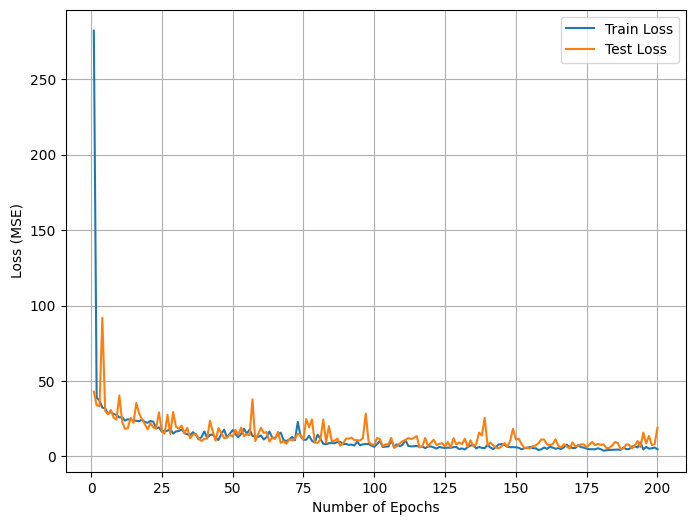

In [17]:
# Plotting the losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Evaluate the model performance on the test set using several metrics

# Set the model to evaluation mode
model.eval()

# Collect all predictions and true values
test_preds = list()
y_test_flat = list()

with torch.no_grad():
    
    for lstm_input, mlp_input, labels in test_loader:
        
        # Move data to the specified device (CPU or GPU)
        lstm_input, mlp_input, labels = (
            lstm_input.to(device),
            mlp_input.to(device),
            labels.to(device),
        )

        # Predict and collect predictions
        outputs = model(lstm_input, mlp_input)
        test_preds.append(outputs.squeeze().cpu().numpy())
        y_test_flat.append(labels.cpu().numpy())

# Flatten predictions and true labels
test_preds = np.concatenate(test_preds, axis=0)
y_test_flat = np.concatenate(y_test_flat, axis=0)

# Regression evaluation metrics
mse = mean_squared_error(y_test_flat, test_preds)
mae = mean_absolute_error(y_test_flat, test_preds)
mape = mean_absolute_percentage_error(y_test_flat, test_preds)
r2 = r2_score(y_test_flat, test_preds)
cv_rmse = np.sqrt(mse) / np.mean(y_test_flat)

# Store test results in a dictionary
test_result = {
    "Test MSE": mse,
    "Test MAE": mae,
    "Test MAPE": mape,
    "Test R2": r2,
    "Test CV-RMSE": cv_rmse,
}

# Print test results
print("Test Results:")
for metric, value in test_result.items():
    print(f"{metric}: {value:.4f}")

Test Results:
Test MSE: 19.0066
Test MAE: 0.3634
Test MAPE: 0.0305
Test R2: 0.9970
Test CV-RMSE: 0.0565


In [19]:
# Define a custom function to handle numpy types
def handle_numpy_types(obj):
    if isinstance(obj, np.float32):
        return float(obj)  # Convert numpy.float32 to Python float
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

# Save the dictionary as a JSON file with the custom handler
output_file = "test_result.json"
with open(output_file, "w") as f:
    json.dump(test_result, f, indent=4, default=handle_numpy_types)

In [21]:
# Save the trained model
model_path = os.path.join(model_files, "deep_fusion_model.pth")
torch.save(model, model_path)

# END